In [1]:
!pip install pulp
!pip install yfinance


In [3]:
!pip install cvxpy
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import cvxpy as cp
import scipy.linalg as la
import pulp


In [4]:
import math

## how we load data from yahoo finance

#### Short-term corporate bond data

In [223]:

T = 1 # Number of days in time period
R = []
assets = ["SCHJ","IGSB","VCSH","SPSB","XBIL","RATE","ICSH"]

for bond in assets:
    data = yf.Ticker(bond)
    # 我先改成1年， 这个之后可以随时改成想要的时段
    df = data.history(period = "1y")

    # close values on that day
    close = df['Close'].values

    # convert day to day close values to return
    returns = (close[T:] - close[:-T])/close[:-T]
    R.append(returns)
#Return
R = np.array(R).T

#Mean return
r = np.mean(R,axis=0)*252
#Covariance matrix: a measure of strength of correlation between two variable or more set of variables.
S = np.cov(R.T)*252

## US Treasury Bond in past 1 years

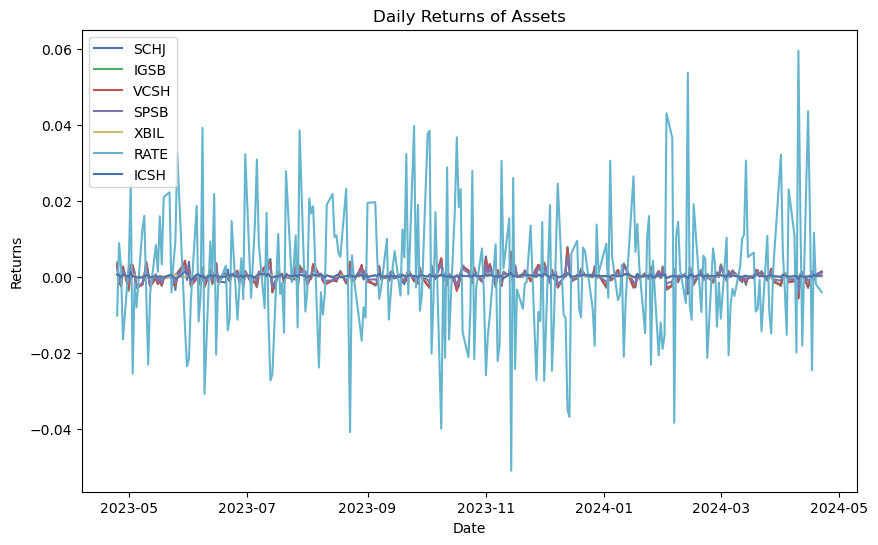

In [133]:
# Get the date index from the DataFrame
dates = df.index[T:]

# Plot returns against time
plt.figure(figsize=(10, 6))
for i in range(len(assets)):
    plt.plot(dates, R[:, i], label=assets[i])

plt.title('Daily Returns of Assets')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

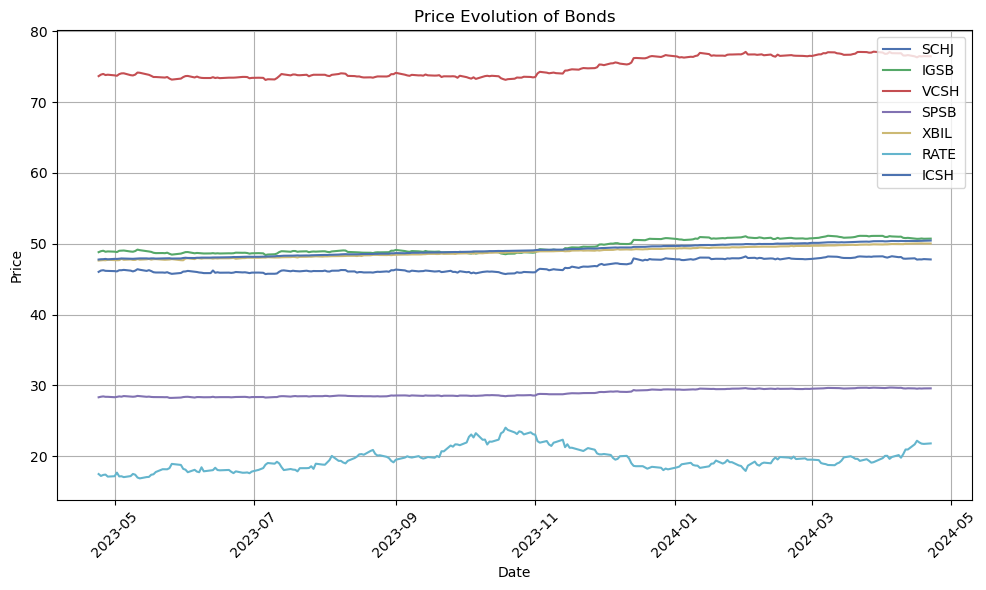

In [131]:
# Create a single plot for all stocks
plt.figure(figsize=(10, 6))

# Plot price evolution of each stock
for bond in assets:
    data = yf.Ticker(bond)
    df = data.history(period = "1y")
    plt.plot(df.index, df["Open"], label=bond)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price Evolution of Bonds")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

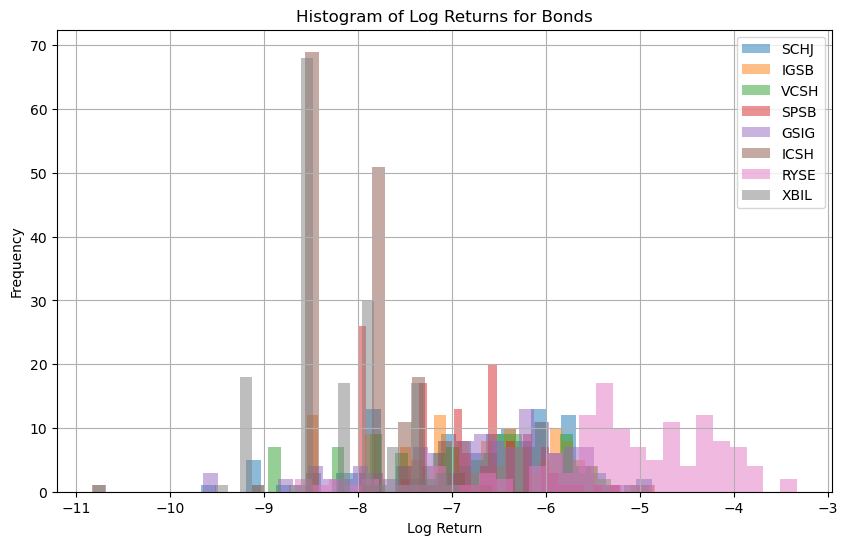

In [56]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for each bond
for i, bond in enumerate(assets):
    # Filter out non-finite values
    valid_log_R = log_R[:, i][np.isfinite(log_R[:, i])]
    # Plot histogram
    ax.hist(valid_log_R, bins=30, alpha=0.5, label=bond)

# Set labels and title
ax.set_xlabel('Log Return')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Log Returns for Bonds')
# Add legend
ax.legend()
# Display grid
ax.grid(True)
# Show plot
plt.show()

# We consider risk as MAD first, all these models are model 1x




# model 1A
when we minimize MAD under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
&  \sum_j x_j r_j = r_0 \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [251]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
r0 = 0.2
print(n,T,r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


7 250 0.2
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/4d5ecc2d438949b9b6f6b22036b2f857-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/4d5ecc2d438949b9b6f6b22036b2f857-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4014 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 252 (-250) rows, 257 (0) columns and 2014 (-2000) elements
Perturbing problem by 0.001% of 0.00058024048 - largest nonzero change 9.9716308e-07 ( 0.19432349%) - largest zero change 9.8560938e-07
0  Obj -0 Primal inf 2.4637498 (2)
31  Obj -0.022450074 Primal inf 2080.7493 (157)
65  Obj -0.04989712 Primal inf 2911.1197 (168)
99  Obj -0.076070473 Primal inf 2752.1406 (139)
135  Obj -0

# model 1B
when we maximize return under a specified MAD constrait $m_0$
$$
\begin{gathered}
\operatorname{maximize} \sum_j x_j r_j  \\
\text { subject to } \sum_j x_j=1 \\
  \frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \leq m_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize}  \sum_j x_j r_j   \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& \frac{1}{T} \sum_{t=1}^T y_t \leq m_0  \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [215]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
m0 = 0.05
print(n,T,r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob +=  (1/T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


7 250 0.1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/aeb670b879ec48cc85a91c6529ae57b2-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/aeb670b879ec48cc85a91c6529ae57b2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4257 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 252 (-250) rows, 257 (0) columns and 2257 (-2000) elements
Perturbing problem by 0.001% of 0.14969203 - largest nonzero change 8.5340171e-05 ( 0.16517476%) - largest zero change 4.9929803e-05
0  Obj -0 Primal inf 29.390268 (2) Dual inf 0.5035517 (7)
80  Obj 0.26161846 Primal inf 310.78829 (173)
160  Obj 0.26018925 Primal inf 410.49097 (93)
240  Obj 0.25891396 Primal inf 504.78132 (

## model 1C
when combine return and risk together with $\mu$

$$
\begin{gathered}
\operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{aligned}
& \operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& x_j \geq 0 \quad j=1,2, \ldots, n \\
& y_t \geq 0 \quad t=1,2, \ldots, T . \\
&
\end{aligned}
$$

below is pulp implementation

In [219]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
mu = 0.5
print(n,T,mu)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)) * mu - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


7 250 0.5
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/813259884f3f4cb3a478c17beb37eef1-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/813259884f3f4cb3a478c17beb37eef1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 506 COLUMNS
At line 4771 RHS
At line 5273 BOUNDS
At line 5274 ENDATA
Problem MODEL has 501 rows, 257 columns and 4007 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 251 (-250) rows, 257 (0) columns and 2007 (-2000) elements
Perturbing problem by 0.001% of 0.056322878 - largest nonzero change 8.5042014e-05 ( 0.32919536%) - largest zero change 0
0  Obj -0 Primal inf 0.74305889 (1) Dual inf 0.23299896 (7)
80  Obj 0.043049271 Primal inf 323.31625 (171)
135  Obj -0.00046143057 Primal inf 33.989441 (119)
215  Obj -0.01296628 Primal inf 11.011758 (39

## Efficient Frontier for 1xx model

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5d63815b0494420fb873511a0f6929fe-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/5d63815b0494420fb873511a0f6929fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 507 COLUMNS
At line 4772 RHS
At line 5275 BOUNDS
At line 5276 ENDATA
Problem MODEL has 502 rows, 257 columns and 4014 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 0.0015888228 - largest nonzero change 4.9890025e-06 ( 11.070961%) - largest zero change 4.0819758e-06
0  Obj -0 Primal inf 0.1709639 (1)
34  Obj -2.2067155e-05 Primal inf 67.106466 (237)
81  Obj -8.1831135e-05 Primal inf 308.97006 (250)
132  Obj 

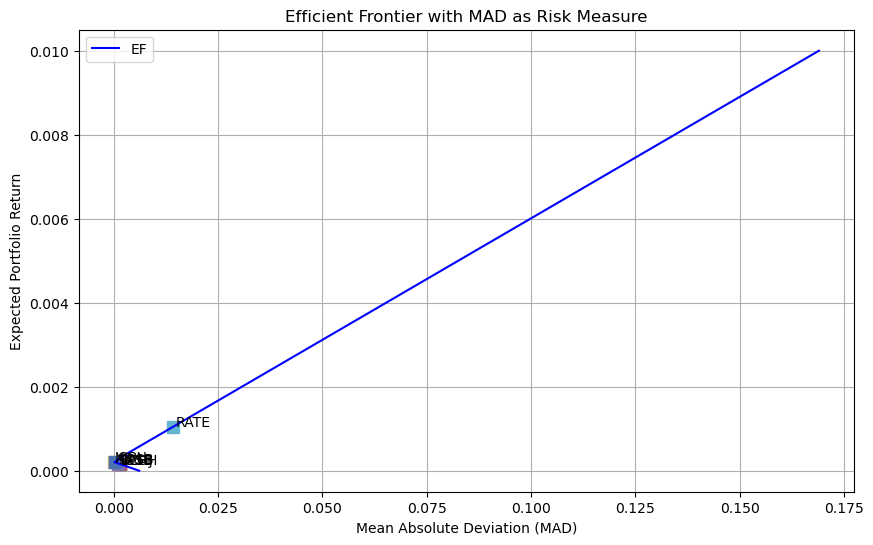

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from pulp import *

# Define the data
assets = ["SCHJ","IGSB","VCSH","SPSB","XBIL","RATE","ICSH"]

# Fetch historical data for each asset and calculate daily returns
R = []
for bond in assets:
    data = yf.Ticker(bond)
    df = data.history(period = '1y')
    close = df["Close"].values
    returns = (close[1:] - close[:-1]) / close[:-1]
    R.append(returns)

R = np.array(R).T

# Calculate mean return and mean absolute deviation for each asset
mean_return = np.mean(R, axis=0)
mean_absolute_deviation = np.mean(np.abs(R - mean_return), axis=0)

# Define the efficient frontier function
def efficient_frontier(R, assets):
    # Define the data
    n = len(assets)  # Number of assets
    T = len(R[:, 0])  # Number of time periods

    m0_array = np.linspace(0.0, 0.01, 50)
    risk_array = np.zeros_like(m0_array)
    portfolio_returns = []
    portfolio_mads = []

    for i, m0 in enumerate(m0_array):
        # Create a LP problem
        prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

        # Define decision variables
        x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
        y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

        # Define objective function
        prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

        # Define constraints
        for t in range(T):
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) <= y[t],
                f"Upper_constraint_{t}",
            )
            prob += (
                lpSum(x[j] * (R[t][j] - mean_return[j]) for j in range(n)) >= -y[t],
                f"Lower_constraint_{t}",
            )

        prob += lpSum(mean_return[j] * x[j] for j in range(n)) == m0

        prob += lpSum(x) == 1, "Sum_of_weights"

        # Solve the problem
        prob.solve()
        
        # Calculate portfolio return and MAD
        portfolio_return = value(lpSum(mean_return[j] * x[j] for j in range(n)))
        portfolio_mad = value((1 / T) * lpSum(y[t] for t in range(T)))

        # Store portfolio return and MAD
        portfolio_returns.append(portfolio_return)
        portfolio_mads.append(portfolio_mad)

        # Store risk
        risk_array[i] = portfolio_mad
    
    return risk_array, portfolio_returns, portfolio_mads

# Calculate efficient frontier points
risk_array, portfolio_returns, portfolio_mads = efficient_frontier(R, assets)

# Fit a linear regression line to the efficient frontier points
slope, intercept, _, _, _ = stats.linregress(risk_array, portfolio_returns)
efficient_line = slope * risk_array + intercept

# Plot both plots on the same graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot daily return versus mean absolute deviation
for i, asset in enumerate(assets):
    ax.plot(mean_absolute_deviation[i], mean_return[i], "s", ms=8)
    ax.text(mean_absolute_deviation[i] * 1.03, mean_return[i], asset)

#ax.set_xlim(0, 1.1 * np.max(mean_absolute_deviation))
#ax.axhline(0, color="r", linestyle="--")
ax.set_title("Daily return versus Mean Absolute Deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

# Plot efficient frontier
#ax.plot(risk_array, efficient_line, label='Efficient Frontier Line', color='red')
ax.plot(portfolio_mads, portfolio_returns, color='blue', label='EF')
ax.set_xlabel('Mean Absolute Deviation (MAD)')
ax.set_ylabel('Expected Portfolio Return')
ax.legend()
plt.title('Efficient Frontier with MAD as Risk Measure')

plt.show()

# Efficient frontier

Let us use model 1B to compute the efficient frontier

In [31]:
from pulp import *
import numpy as np

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0]) +1 # Number of time periods

# Initialize risk_array
m0_array = np.linspace(0.0, 0.01, 50)
risk_array = np.zeros(len(m0_array))

print("Dimensions of R:", R.shape)
print("Number of time periods (T):", T)

# Loop over m0_array
for i in range(len(m0_array)):

    r0 = m0_array[i]

    # Create a LP problem
    prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

    # Define decision variables
    x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
    y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

    # Define objective function
    prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

    # Define constraints
    for t in range(T):
        prob += lpSum(x[j] * (R[j][t] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
        prob += lpSum(x[j] * (R[j][t] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

    prob += lpSum(r[j] * x[j] for j in range(n)) == r0

    prob += lpSum(x) == 1, "Sum_of_weights"

    # Solve the problem
    prob.solve()

    # Check if problem is solved successfully
    if LpStatus[prob.status] == "Optimal":
        risk_array[i] = value( (1/T) * lpSum(y[t] for t in range(T)))
        print(f"Solution found for m0_array[{i}]: {m0_array[i]}")
    else:
        print(f"No solution found for m0_array[{i}]: {m0_array[i]}")

print("Risk array:", risk_array)


Dimensions of R: (249, 9)
Number of time periods (T): 250


IndexError: index 8 is out of bounds for axis 0 with size 8

In [24]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods

m0_array = np.linspace(0.0,0.01,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  # Define the data
  n = len(assets)  # Number of assets
  T = len(R[:,0])  # Number of time periods
  r0 = m0_array[i]

  # Create a LP problem
  prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

  # Define decision variables
  x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
  y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

  # Define objective function
  prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

  # Define constraints
  for t in range(T):
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

  prob += lpSum(r[j] * x[j] for j in range(n)) == r0

  prob += lpSum(x) == 1, "Sum_of_weights"

  # Solve the problem
  prob.solve()
  risk_array[i] = value( (1/T) * lpSum(y[t] for t in range(T)))

print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


IndexError: index 8 is out of bounds for axis 0 with size 8

In [28]:
print(T)

9


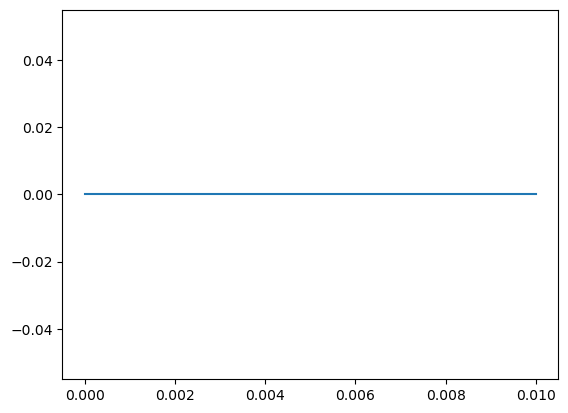

In [32]:
plt.figure()
plt.plot(m0_array, risk_array)

# Now we consider risk as total variance of the portfolio, all these models are model 2x


# model 2A
when we minimize variance under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2 \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

In [252]:
# centered return
T=252
R_c = 0. * R
for j in range(len(R[0, :])):
    R_c[:, j] = R[:, j] - r[j]

# print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:, 0])):
    sig = sig + np.outer(R_c[i, :], R_c[i, :])
sig = sig / T


r0 = 0.2
n = len(R[0, :])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

X = cp.Variable((n, 1))
Objective = cp.Minimize(cp.quad_form(X, sig))
constraints = [e.T @ X == 1, X >= 0, rq.T @ X >= r0]
problem = cp.Problem(Objective, constraints)

result = problem.solve()
print(X.value)

[[0.04857817]
 [0.05053854]
 [0.04737217]
 [0.04693505]
 [0.04588758]
 [0.70587707]
 [0.05481141]]


In [253]:
print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )

expected portfolio [[0.04857817 0.05053854 0.04737217 0.04693505 0.04588758 0.70587707
  0.05481141]]
expected return : [0.20000001]
Mean variance: 0    0.039523
Name: 0, dtype: float64


### Model 2B

In [247]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T


v0 = 0.05
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(rq.T@X)
constraints = [e.T@X == 1, X >= 0, cp.quad_form(X,sig) <= v0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )

expected portfolio [[4.92515414e-06 1.61655557e-06 4.98344697e-06 5.41299100e-06
  5.89176969e-06 8.09207526e-01 1.90769645e-01]]
expected return : [0.2249205]
Mean variance: 0    0.05
Name: 0, dtype: float64
Mean std: 0    0.223607
Name: 0, dtype: float64


Text(0.5, 1.0, 'Efficient Frontier')

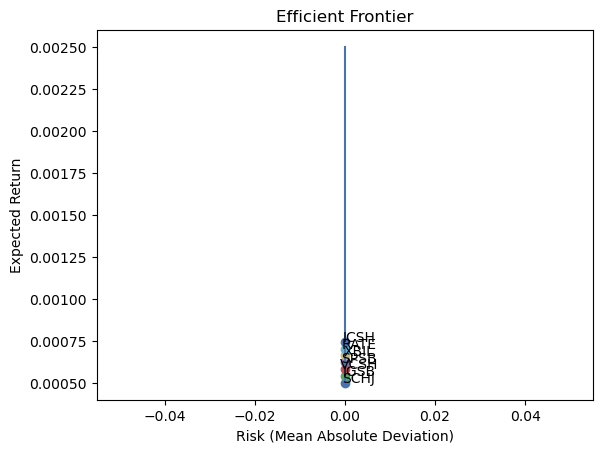

In [111]:
plt.figure()
plt.plot(risk_array, m0_array)

for i, stock in enumerate(assets):
    plt.annotate(
        stock,
        (risk_array[i], m0_array[i]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="center",
    )

for i, stock in enumerate(assets):
    plt.scatter(risk_array[i], m0_array[i], label=stock)
plt.xlabel("Risk (Mean Absolute Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")

### Model 2C

In [248]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

mu = 0.5
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(mu * rq.T@X - cp.quad_form(X,sig))
constraints = [e.T@X == 1, X >= 0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )

expected portfolio [[-5.44838805e-24  3.06094328e-23  7.22033471e-25  1.25322829e-23
   2.26938961e-23  9.40799812e-01  5.92001876e-02]]
expected return : [0.25254277]
Mean variance: 0    0.063055
Name: 0, dtype: float64
Mean std: 0    0.251107
Name: 0, dtype: float64


### Efficient Frontier using 2B

In [113]:
### Efficient Frontier
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
e = np.ones((n,1))
rq = r.reshape(n,1)

m0_array = np.linspace(0.0005,0.0025,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  r0 = m0_array[i]

  X = cp.Variable((n,1))
  Objective = cp.Minimize(cp.quad_form(X,sig))
  constraints = [e.T@X == 1, X >= 0, rq.T@X == r0]
  problem = cp.Problem(Objective,constraints)

  result = problem.solve()

  risk_array[i] = (X.value.T @ sig @ X.value)[0,0]**0.5

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


AttributeError: 'NoneType' object has no attribute 'T'

## Optimization Problem

Choose a risk tolerance $q > 0$:

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} - q \mathbf{r}^T \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{x} \geq 0 \\
\end{align*}

In [ ]:
n = len(assets)
q = 0.1
e = np.ones(n)
X = cp.Variable(n)

obj = cp.Minimize(cp.quad_form(X,S) - q*r@X)
constraints = [e@X == 1, X >= 0]
problem = cp.Problem(obj,constraints)

result = problem.solve()
X.value

## Optimization Problem

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{r}^T \mathbf{x} = \mu \\
& \mathbf{x} \geq 0 \\
\end{align*}

case mu = 0.01,   minimize risk sigma = 0.001

case mu = 0.02,  minimize risk sigma = 0.003

case mu = 0.05,  minimize risk  sigma = 0.010



In [80]:
n = len(assets)
e = np.ones((n,1))
r = r.reshape(n,1)
mu = 0.001

M = np.block([[2*S,-r,-e],[r.T,0,0],[e.T,0,0]])
b = np.block([[np.zeros((n,1))],[mu],[1]])

x = la.solve(M,b)
print(x)

[[ 3.39343202e-01]
 [ 1.02254054e+01]
 [-1.55086624e+00]
 [-6.75216205e+00]
 [-2.47419324e+00]
 [ 1.77206371e+01]
 [ 8.85100469e-01]
 [-1.73932646e+01]
 [ 1.13455577e-01]
 [-2.37020940e-05]]


In [78]:
!pip install PyPortfolioOpt

In [227]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting

In [228]:
import pandas as pd
import yfinance as yf

T = 1  # Number of days in time period
assets = ["SCHJ","IGSB","VCSH","SPSB","XBIL","RATE","ICSH"]

# Initialize a dictionary to store stock prices
prices_dict = {}

# Loop through each stock and retrieve prices
for bond in assets:
    data = yf.Ticker(bond)
    df = data.history(period = '1y')
    prices_dict[bond] = df["Close"]

# Create a DataFrame from the prices dictionary
df_prices = pd.DataFrame(prices_dict)

# Display the DataFrame
print(df_prices.head())

                                SCHJ       IGSB       VCSH       SPSB  \
Date                                                                    
2023-04-24 00:00:00-04:00  46.082901  48.817883  73.752556  28.354979   
2023-04-25 00:00:00-04:00  46.223194  49.001293  73.994232  28.421970   
2023-04-26 00:00:00-04:00  46.179646  48.914410  73.897552  28.393257   
2023-04-27 00:00:00-04:00  46.073223  48.817883  73.713860  28.345411   
2023-04-28 00:00:00-04:00  46.160301  48.953026  73.897552  28.393257   

                                XBIL       RATE       ICSH  
Date                                                        
2023-04-24 00:00:00-04:00  47.635590  17.370197  47.778358  
2023-04-25 00:00:00-04:00  47.654583  17.191927  47.806881  
2023-04-26 00:00:00-04:00  47.654583  17.344198  47.825901  
2023-04-27 00:00:00-04:00  47.664070  17.388025  47.816387  
2023-04-28 00:00:00-04:00  47.664070  17.100563  47.844913  


In [229]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df_prices)
S = CovarianceShrinkage(df_prices).ledoit_wolf()

In [230]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [231]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('SCHJ', 0.0), ('IGSB', 0.0), ('VCSH', 0.0), ('SPSB', 0.08138), ('XBIL', 0.4315), ('RATE', 0.01196), ('ICSH', 0.47517)])


In [232]:
ret_optimal, vol_optimal, sharpe_ration = ef.portfolio_performance(verbose=True)

Expected annual return: 5.5%
Annual volatility: 0.9%
Sharpe Ratio: 4.08


In [233]:
from pypfopt import EfficientFrontier
ef_curve = EfficientFrontier(mu, S, weight_bounds = (0,1))
ef_curve

/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


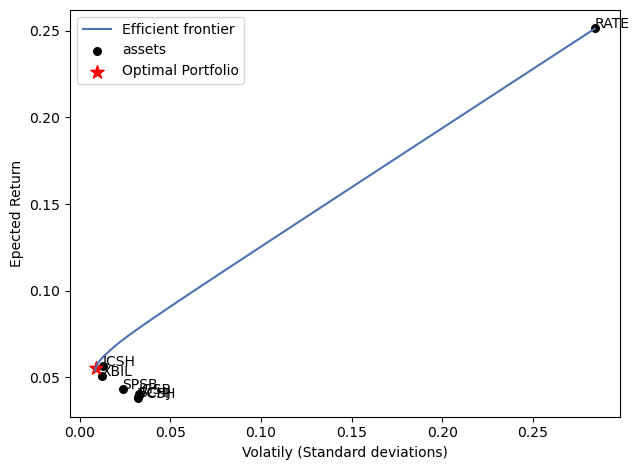

In [234]:
from pypfopt import plotting
fig,ax = plt.subplots()
plotting.plot_efficient_frontier(ef_curve, ax=ax, show_assets = True)

ax.scatter(vol_optimal, ret_optimal, marker = "*", s=100, c="r", label = "Optimal Portfolio")

for i, txt in enumerate(ef.tickers):
    ax.annotate(txt, ((np.diag(ef.cov_matrix) ** (1/2))[i], ef. expected_returns[i]))
    
    
ax.set_xlabel("Volatily (Standard deviations)")
ax.set_ylabel("Epected Return")
ax.legend()
plt.show()